# draft

In [ ]:



import os
import cv2
import numpy as np
import mediapipe as mp
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import json
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader  # Add this import
import numpy as np
import os
import cv2
import mediapipe as mp
from pathlib import Path
import json
from tqdm import tqdm
import matplotlib.pyplot as plt


# 2. Add error checking for required packages
def check_dependencies():
    try:
        import torch
        import mediapipe
        import cv2
        import numpy
    except ImportError as e:
        print(f"Missing required package: {str(e)}")
        print("Please install required packages:")
        print("pip install torch torchvision mediapipe opencv-python numpy")
        raise


# Usage example:
preprocessor = LandmarkPreprocessor('sample/', 'processed_data/')
landmark_data = preprocessor.process_dataset()

# Create dataset and dataloader
dataset = HandLandmarkDataset('processed_data/landmarks.json')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm



# Usage
dataset = HandLandmarkDataset('processed_data/landmarks.json')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

trainer = GANTrainer(generator, discriminator)
trainer.train(dataloader, num_epochs=200)

# Save model
torch.save({
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
}, 'hand_landmark_gan.pth')


import torch
import torch.nn as nn
import numpy as np

# Constants
LANDMARK_POINTS = 21
LANDMARK_DIMS = 3
LATENT_DIM = 100
HIDDEN_DIM = 256


        return landmarks.view(-1, LANDMARK_POINTS, LANDMARK_DIMS)



def letter_to_onehot(letter):
    # Convert letter to one-hot encoding
    encoding = torch.zeros(26)
    encoding[ord(letter.lower()) - ord('a')] = 1
    return encoding

# Training utilities
def generate_noise(batch_size):
    return torch.randn(batch_size, LATENT_DIM)

# Loss functions
adversarial_loss = nn.BCELoss()

# Example usage:
generator = Generator()
discriminator = Discriminator()

# Generate fake landmarks for letter 'A'
z = generate_noise(1)
letter = letter_to_onehot('A').unsqueeze(0)
fake_landmarks = generator(z, letter)

In [5]:
# main.py
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import cv2
import mediapipe as mp
from pathlib import Path
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1. Constants and Utilities
LANDMARK_POINTS = 21
LANDMARK_DIMS = 3
LATENT_DIM = 100
HIDDEN_DIM = 256

adversarial_loss = nn.BCELoss()

def letter_to_onehot(letter):
    encoding = torch.zeros(26)
    encoding[ord(letter.lower()) - ord('a')] = 1
    return encoding

def generate_noise(batch_size):
    return torch.randn(batch_size, LATENT_DIM)

def visualize_landmarks(landmarks, size=400):
    image = np.zeros((size, size, 3), dtype=np.uint8)
    landmarks = landmarks.copy()
    landmarks[:, 0] *= size
    landmarks[:, 1] *= size
    landmarks = landmarks.astype(int)
    
    for i in range(len(landmarks)):
        cv2.circle(image, (landmarks[i, 0], landmarks[i, 1]), 5, (255, 255, 255), -1)
    return image

# 2. Data Preprocessing
class LandmarkPreprocessor:
    def process_dataset(self):
        if not self.data_root.exists():
            raise FileNotFoundError(f"Data root not found: {self.data_root}")
        
        self.save_path.mkdir(parents=True, exist_ok=True)
     
    def __init__(self, data_root, save_path):
        self.data_root = Path(data_root)
        self.save_path = Path(save_path)
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(static_image_mode=True, max_num_hands=1)
        
    def extract_landmarks(self, image_path):
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = self.hands.process(image)
        
        if results.multi_hand_landmarks:
            landmarks = np.array([[lm.x, lm.y, lm.z] 
                                for lm in results.multi_hand_landmarks[0].landmark])
            return landmarks
        return None

    def process_dataset(self):
        landmark_data = []
        
        for user_dir in tqdm(self.data_root.glob('u*')):
            for img_path in user_dir.glob('*.jpg'):
                landmarks = self.extract_landmarks(img_path)
                if landmarks is not None:
                    landmark_data.append({
                        'landmarks': landmarks.tolist(),
                        'label': img_path.stem[0],  # First character is the letter
                        'user': user_dir.name
                    })
        
        # Save preprocessed data
        with open(self.save_path / 'landmarks.json', 'w') as f:
            json.dump(landmark_data, f)
        return landmark_data

# 3. Dataset and Augmentation
class HandLandmarkDataset(Dataset):
    def __init__(self, data_path, augment=True):
        self.data_path = Path(data_path)
        if not self.data_path.exists():
            raise FileNotFoundError(f"Data file not found: {data_path}")
        with open(data_path) as f:
            self.data = json.load(f)
        self.augment = augment
        
    def augment_landmarks(self, landmarks):
        landmarks = np.array(landmarks)
        
        # Random rotation (-15 to 15 degrees)
        angle = np.random.uniform(-15, 15)
        rotation_matrix = np.array([
            [np.cos(np.deg2rad(angle)), -np.sin(np.deg2rad(angle))],
            [np.sin(np.deg2rad(angle)), np.cos(np.deg2rad(angle))]
        ])
        landmarks[:, :2] = landmarks[:, :2] @ rotation_matrix
        
        # Random scale (0.8 to 1.2)
        scale = np.random.uniform(0.8, 1.2)
        landmarks *= scale
        
        # Random translation (-0.1 to 0.1)
        translation = np.random.uniform(-0.1, 0.1, size=3)
        landmarks += translation
        
        return landmarks

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        landmarks = np.array(item['landmarks'])
        
        if self.augment:
            landmarks = self.augment_landmarks(landmarks)
            
        return {
            'landmarks': torch.FloatTensor(landmarks),
            'label': letter_to_onehot(item['label']),
            'user': item['user']
        }

# 4. Model Architecture
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Input: latent vector + one-hot encoded letter (100 + 26)
            nn.Linear(LATENT_DIM + 26, HIDDEN_DIM),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(HIDDEN_DIM),
            
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM * 2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(HIDDEN_DIM * 2),
            
            # Output: 21 landmarks × 3 coordinates
            nn.Linear(HIDDEN_DIM * 2, LANDMARK_POINTS * LANDMARK_DIMS),
            nn.Tanh()  # Normalize outputs to [-1, 1]
        )
        
    def forward(self, z, letter_encoding):
        x = torch.cat([z, letter_encoding], dim=1)
        landmarks = self.model(x)
        return landmarks.view(-1, LANDMARK_POINTS, LANDMARK_DIMS)  # Add this line

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input: flattened landmarks (21*3) + letter encoding (26)
            nn.Linear(LANDMARK_POINTS * LANDMARK_DIMS + 26, HIDDEN_DIM),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            # Output: single value for real/fake
            nn.Linear(HIDDEN_DIM // 2, 1),
            nn.Sigmoid()
        )
    
    def forward(self, landmarks, letter_encoding):
        # Concatenate landmarks and letter encoding
        x = torch.cat([landmarks.view(-1, LANDMARK_POINTS * LANDMARK_DIMS), 
                      letter_encoding], dim=1)
        return self.model(x)

# 5. Training
class GANTrainer:
    def __init__(self, generator, discriminator, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.device = device
        
        # Optimizers
        self.g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        # History for plotting
        self.g_losses = []
        self.d_losses = []

    def train_epoch(self, dataloader, epoch):
        for batch in tqdm(dataloader, desc=f'Epoch {epoch}'):
            real_landmarks = batch['landmarks'].to(self.device)
            labels = batch['label'].to(self.device)
            batch_size = real_landmarks.size(0)
            
            # Ground truths
            valid = torch.ones(batch_size, 1).to(self.device)
            fake = torch.zeros(batch_size, 1).to(self.device)

            # Train Discriminator
            self.d_optimizer.zero_grad()
            
            # Real landmarks
            d_real = self.discriminator(real_landmarks, labels)
            d_real_loss = adversarial_loss(d_real, valid)
            
            # Fake landmarks
            z = generate_noise(batch_size).to(self.device)
            fake_landmarks = self.generator(z, labels)
            d_fake = self.discriminator(fake_landmarks.detach(), labels)
            d_fake_loss = adversarial_loss(d_fake, fake)
            
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            self.d_optimizer.step()

            # Train Generator
            self.g_optimizer.zero_grad()
            
            gen_landmarks = self.generator(z, labels)
            d_output = self.discriminator(gen_landmarks, labels)
            g_loss = adversarial_loss(d_output, valid)
            
            g_loss.backward()
            self.g_optimizer.step()

            # Save losses
            self.g_losses.append(g_loss.item())
            self.d_losses.append(d_loss.item())

    def train(self, dataloader, num_epochs=200):
        for epoch in range(num_epochs):
            self.train_epoch(dataloader, epoch)
            
            if (epoch + 1) % 10 == 0:
                self.plot_losses()
                self.generate_samples()
    
    def plot_losses(self):
        plt.figure(figsize=(10,5))
        plt.plot(self.g_losses, label='Generator')
        plt.plot(self.d_losses, label='Discriminator')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    
    def generate_samples(self, letters=['A', 'B', 'C']):
        self.generator.eval()
        with torch.no_grad():
            for letter in letters:
                z = generate_noise(1).to(self.device)
                letter_enc = letter_to_onehot(letter).unsqueeze(0).to(self.device)
                fake_landmarks = self.generator(z, letter_enc)
                
                # Visualize landmarks (assuming you have visualization function)
                landmarks = fake_landmarks.cpu().numpy()[0]
                visualize_landmarks(landmarks)
                plt.title(f'Generated Landmarks for letter {letter}')
                plt.show()
        self.generator.train()

# 6. Testing and Evaluation
class ModelTester:
    def __init__(self, model_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
        checkpoint = torch.load(model_path)
        self.generator = Generator().to(device)
        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.device = device
        self.generator.eval()

    def generate_landmark(self, letter):
        with torch.no_grad():
            z = generate_noise(1).to(self.device)
            letter_enc = letter_to_onehot(letter).unsqueeze(0).to(self.device)
            landmarks = self.generator(z, letter_enc)
            return landmarks.cpu().numpy()[0]

    def evaluate_generation(self, letters=['A', 'B', 'C']):
        results = {}
        for letter in letters:
            landmarks = self.generate_landmark(letter)
            vis_image = visualize_landmarks(landmarks)
            results[letter] = {
                'landmarks': landmarks,
                'visualization': vis_image
            }
        return results

# 7. Main Execution
def main():
    try:
        # Preprocessing
        preprocessor = LandmarkPreprocessor('sample/', 'processed_data/')
        landmark_data = preprocessor.process_dataset()

        # Dataset creation
        dataset = HandLandmarkDataset('processed_data/landmarks.json')
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

        # Model initialization and training
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        generator = Generator().to(device)
        discriminator = Discriminator().to(device)
        trainer = GANTrainer(generator, discriminator)

        trainer.train(dataloader, num_epochs=200)

        # Save model with directory creation
        save_path = Path('models')
        save_path.mkdir(exist_ok=True)
        torch.save({
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
        }, save_path / 'hand_landmark_gan.pth')

        # Testing
        tester = ModelTester(save_path / 'hand_landmark_gan.pth')
        results = tester.evaluate_generation(['A', 'B', 'C'])

    except Exception as e:
        print(f"Error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    main()

NameError: name 'Dataset' is not defined

# Draft end

# IMPORTS

In [50]:
# General Libraries
import os
import json
import random
from pathlib import Path

# Data Handling
import numpy as np
import pandas as pd

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Computer Vision and Visualization
import cv2

# Mediapipe for Hand Landmark Detection
import mediapipe as mp

# Utility Libraries
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split

# Progress Bar Library
from tqdm import tqdm  # Import tqdm for progress bars


import matplotlib.pyplot as plt


# Preprocess

In [51]:
class LandmarkPreprocessor:
    def __init__(self, data_root, save_path):
        self.data_root = Path(data_root)
        self.save_path = Path(save_path)
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(static_image_mode=True, max_num_hands=1)
        
    def extract_landmarks(self, image_path):
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = self.hands.process(image)
        
        if results.multi_hand_landmarks:
            landmarks = np.array([[lm.x, lm.y, lm.z] 
                                for lm in results.multi_hand_landmarks[0].landmark])
            return landmarks
        return None

    def process_dataset(self):
        landmark_data = []
        for img_path in tqdm(self.data_root.glob('*.jpg')):  # Process all images in the directory
            landmarks = self.extract_landmarks(img_path)
            if landmarks is not None:
                landmark_data.append({
                    'landmarks': landmarks.tolist(),
                    'label': img_path.stem[0],  # The letter is still indicated by the first character of filename
                    'user': img_path.stem[1:]  # Assuming the rest of the filename represents the user ID
                })
        
        # Save preprocessed data
        self.save_path.mkdir(parents=True, exist_ok=True)
        with open(self.save_path / 'landmarks.json', 'w') as f:
            json.dump(landmark_data, f)
        return landmark_data


# augmentation

In [52]:
import torch
from torch.utils.data import Dataset  # Import the Dataset class
import numpy as np
from pathlib import Path
import json

# Augmentation - Adds variability to landmarks during training
class HandLandmarkDataset(Dataset):
    def __init__(self, data_path, augment=True):
        self.data_path = Path(data_path)
        if not self.data_path.exists():
            raise FileNotFoundError(f"Data file not found: {data_path}")
        with open(data_path) as f:
            self.data = json.load(f)
        self.augment = augment

    def augment_landmarks(self, landmarks):
        landmarks = np.array(landmarks)

        # Ensure landmarks are in (N, 3) format
        if landmarks.ndim == 1:
            landmarks = landmarks.reshape(-1, 3)
        elif landmarks.shape[1] != 3:
            raise ValueError(f"Expected landmarks to have shape (N, 3), but got {landmarks.shape}")

        # Random rotation (-15 to 15 degrees) - Around Z-axis (2D-like rotation)
        angle = np.random.uniform(-15, 15)
        rotation_matrix = np.array([
            [np.cos(np.deg2rad(angle)), -np.sin(np.deg2rad(angle)), 0],
            [np.sin(np.deg2rad(angle)), np.cos(np.deg2rad(angle)), 0],
            [0, 0, 1]  # No change to the Z dimension
        ])
        landmarks = landmarks @ rotation_matrix.T

        # Random scale (0.8 to 1.2)
        scale = np.random.uniform(0.8, 1.2)
        landmarks *= scale

        # Random translation (-0.1 to 0.1) - Applied to all 3 dimensions
        translation = np.random.uniform(-0.1, 0.1, size=3)
        landmarks += translation

        return landmarks

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
            item = self.data[idx]
            landmarks = np.array(item['landmarks'], dtype=np.float32)  # Specify dtype
            
            if self.augment:
                landmarks = self.augment_landmarks(landmarks)
                
            return {
                'landmarks': torch.FloatTensor(landmarks),
                'label': letter_to_onehot(item['label']),
                'user': item['user']
            }
        except Exception as e:
            print(f"Error loading item {idx}: {str(e)}")
            # Return a zero tensor as fallback
            return {
                'landmarks': torch.zeros(LANDMARK_POINTS, LANDMARK_DIMS),
                'label': torch.zeros(26),
                'user': 'error'
            }

# Dataloader

In [53]:
# from torch.utils.data import DataLoader

# # Create DataLoader
# def get_dataloader(data_path, batch_size=32, shuffle=True):
#     dataset = HandLandmarkDataset(data_path)
#     return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4)


# Model

In [54]:
import torch
import torch.nn as nn  # Import torch.nn for neural network layers

# Constants for Model Architecture
LATENT_DIM = 100  # Latent dimension for the generator (typically used in GANs)
HIDDEN_DIM = 512  # Number of hidden units in the generator and discriminator layers
LANDMARK_POINTS = 21  # Number of landmarks (e.g., hand landmarks in 2D/3D)
LANDMARK_DIMS = 3  # Dimensionality of each landmark (e.g., x, y, z coordinates)

# Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(LATENT_DIM + 26, HIDDEN_DIM),  # 26 could be the one-hot encoded letter size
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(HIDDEN_DIM),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM * 2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(HIDDEN_DIM * 2),
            nn.Linear(HIDDEN_DIM * 2, LANDMARK_POINTS * LANDMARK_DIMS),
            nn.Tanh()
        )
        
    def forward(self, z, letter_encoding):
        x = torch.cat([z, letter_encoding], dim=1)
        landmarks = self.model(x)
        return landmarks.view(-1, LANDMARK_POINTS, LANDMARK_DIMS)

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(LANDMARK_POINTS * LANDMARK_DIMS + 26, HIDDEN_DIM),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(HIDDEN_DIM // 2, 1),
            nn.Sigmoid()
        )
    
    def forward(self, landmarks, letter_encoding):
        x = torch.cat([landmarks.view(-1, LANDMARK_POINTS * LANDMARK_DIMS), letter_encoding], dim=1)
        return self.model(x)


# Training

In [60]:
class GANTrainer:
    def __init__(self, generator, discriminator, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.device = device
        
        # Optimizers with learning rate scheduling
        self.g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        # Learning rate schedulers
        self.g_scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.g_optimizer, mode='min', patience=5)
        self.d_scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.d_optimizer, mode='min', patience=5)
        
        # Training history
        self.g_losses = []
        self.d_losses = []
        self.best_g_loss = float('inf')
        
        # Set up logging
        self.checkpoint_dir = Path('checkpoints')
        self.checkpoint_dir.mkdir(exist_ok=True)

    def train_epoch(self, dataloader, epoch):
        self.generator.train()
        self.discriminator.train()
        
        epoch_g_losses = []
        epoch_d_losses = []
        
        try:
            for batch_idx, batch in enumerate(tqdm(dataloader, desc=f'Epoch {epoch}')):
                real_landmarks = batch['landmarks'].to(self.device)
                labels = batch['label'].to(self.device)
                batch_size = real_landmarks.size(0)

                # Labels for loss
                valid = torch.ones(batch_size, 1, device=self.device)
                fake = torch.zeros(batch_size, 1, device=self.device)

                # Train Discriminator
                self.d_optimizer.zero_grad()
                
                d_real = self.discriminator(real_landmarks, labels)
                d_real_loss = adversarial_loss(d_real, valid)
                
                z = generate_noise(batch_size).to(self.device)
                fake_landmarks = self.generator(z, labels)
                d_fake = self.discriminator(fake_landmarks.detach(), labels)
                d_fake_loss = adversarial_loss(d_fake, fake)
                
                d_loss = (d_real_loss + d_fake_loss) / 2
                d_loss.backward()
                self.d_optimizer.step()

                # Train Generator
                self.g_optimizer.zero_grad()
                
                gen_landmarks = self.generator(z, labels)
                d_output = self.discriminator(gen_landmarks, labels)
                g_loss = adversarial_loss(d_output, valid)
                
                g_loss.backward()
                self.g_optimizer.step()

                # Record losses
                epoch_g_losses.append(g_loss.item())
                epoch_d_losses.append(d_loss.item())

                # Save checkpoint if best generator loss
                if g_loss.item() < self.best_g_loss:
                    self.best_g_loss = g_loss.item()
                    self.save_checkpoint(epoch, batch_idx)

        except Exception as e:
            print(f"Error during training: {str(e)}")
            self.save_checkpoint(epoch, batch_idx, is_error=True)
            raise

        # Update learning rates
        avg_g_loss = np.mean(epoch_g_losses)
        avg_d_loss = np.mean(epoch_d_losses)
        self.g_scheduler.step(avg_g_loss)
        self.d_scheduler.step(avg_d_loss)
        
        return avg_g_loss, avg_d_loss
    # Previous __init__ and other methods remain same
    
    def generate_samples(self, letters=['A', 'B', 'C']):
        """Generate and visualize sample landmarks for given letters"""
        self.generator.eval()
        try:
            with torch.no_grad():
                for letter in letters:
                    z = generate_noise(1).to(self.device)
                    letter_enc = letter_to_onehot(letter).unsqueeze(0).to(self.device)
                    fake_landmarks = self.generator(z, letter_enc)
                    landmarks = fake_landmarks.cpu().numpy()[0]
                    
                    plt.figure(figsize=(5,5))
                    plt.scatter(landmarks[:,0], landmarks[:,1], c='blue', s=50)
                    plt.title(f'Generated Landmarks for letter {letter}')
                    plt.xlim(-1, 1)
                    plt.ylim(-1, 1)
                    plt.grid(True)
                    plt.show()
                    plt.close()
        finally:
            self.generator.train()

    def train(self, dataloader, num_epochs):
        print(f"Starting training for {num_epochs} epochs...")
        for epoch in tqdm(range(num_epochs), desc="Training Progress"):
            avg_g_loss, avg_d_loss = self.train_epoch(dataloader, epoch)
            self.g_losses.append(avg_g_loss)
            self.d_losses.append(avg_d_loss)
            
            # Print progress every epoch
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print(f"Generator Loss: {avg_g_loss:.4f}")
            print(f"Discriminator Loss: {avg_d_loss:.4f}")
            
            if (epoch + 1) % 5 == 0:
                self.plot_losses()
                self.generate_samples()
                
        print("Training completed!")

    def plot_losses(self):
        """Plot training losses and learning rates"""
        plt.figure(figsize=(12, 6))
        
        # Plot losses
        plt.subplot(1, 2, 1)
        epochs = range(1, len(self.g_losses) + 1)
        plt.plot(epochs, self.g_losses, label='Generator')
        plt.plot(epochs, self.d_losses, label='Discriminator')
        plt.xlabel('Epochs')
        plt.ylabel('Average Loss')
        plt.title('Training Losses')
        plt.legend()
        plt.grid(True)
        
        # Plot learning rates - Fixed dimension issue
        plt.subplot(1, 2, 2)
        g_lr = self.g_optimizer.param_groups[0]['lr']
        d_lr = self.d_optimizer.param_groups[0]['lr']
        
        # Create arrays of same length as epochs
        g_lrs = [g_lr] * len(epochs)
        d_lrs = [d_lr] * len(epochs)
        
        plt.plot(epochs, g_lrs, label='Generator LR')
        plt.plot(epochs, d_lrs, label='Discriminator LR')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        plt.close()



    def save_checkpoint(self, epoch, batch_idx, is_error=False):
        prefix = 'error' if is_error else 'best'
        torch.save({
            'epoch': epoch,
            'batch_idx': batch_idx,
            'generator_state_dict': self.generator.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict(),
            'g_optimizer_state_dict': self.g_optimizer.state_dict(),
            'd_optimizer_state_dict': self.d_optimizer.state_dict(),
            'g_losses': self.g_losses,
            'd_losses': self.d_losses,
        }, self.checkpoint_dir / f'{prefix}_checkpoint.pth')

# Tesring

In [ ]:
class ModelTester:
    def __init__(self, model_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
        checkpoint = torch.load(model_path)
        self.generator = Generator().to(device
                                        )
        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.device = device
        self.generator.eval()

    def generate_landmark(self, letter):
        with torch.no_grad():
            z = generate_noise(1).to(self.device)
            letter_enc = letter_to_onehot(letter).unsqueeze(0).to(self.device)
            landmarks = self.generator(z, letter_enc)
            return landmarks.cpu().numpy()[0]

    def evaluate_generation(self, letters=['A', 'B', 'C']):
        results = {}
        for letter in letters:
            landmarks = self.generate_landmark(letter)
            vis_image = visualize_landmarks(landmarks)
            results[letter] = {
                'landmarks': landmarks,
                'visualization': vis_image
            }
        return results


# MAIN

Step 1: Preprocessing...
Using existing preprocessed data from ./processed_data/landmarks.json
Step 2: Preparing DataLoader...
Step 3: Initializing models...
Step 4: Training GAN...
Starting training for 30 epochs...


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]/s]



Epoch 1/30
Generator Loss: 0.7085
Discriminator Loss: 0.6943


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 50.92it/s]



Epoch 2/30
Generator Loss: 0.7108
Discriminator Loss: 0.6755


Training Progress:  10%|█         | 3/30 [00:00<00:01, 24.78it/s]


Epoch 3/30
Generator Loss: 0.7203
Discriminator Loss: 0.6657


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 45.35it/s]



Epoch 4/30
Generator Loss: 0.7223
Discriminator Loss: 0.6508


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]



Epoch 5/30
Generator Loss: 0.7298
Discriminator Loss: 0.6362


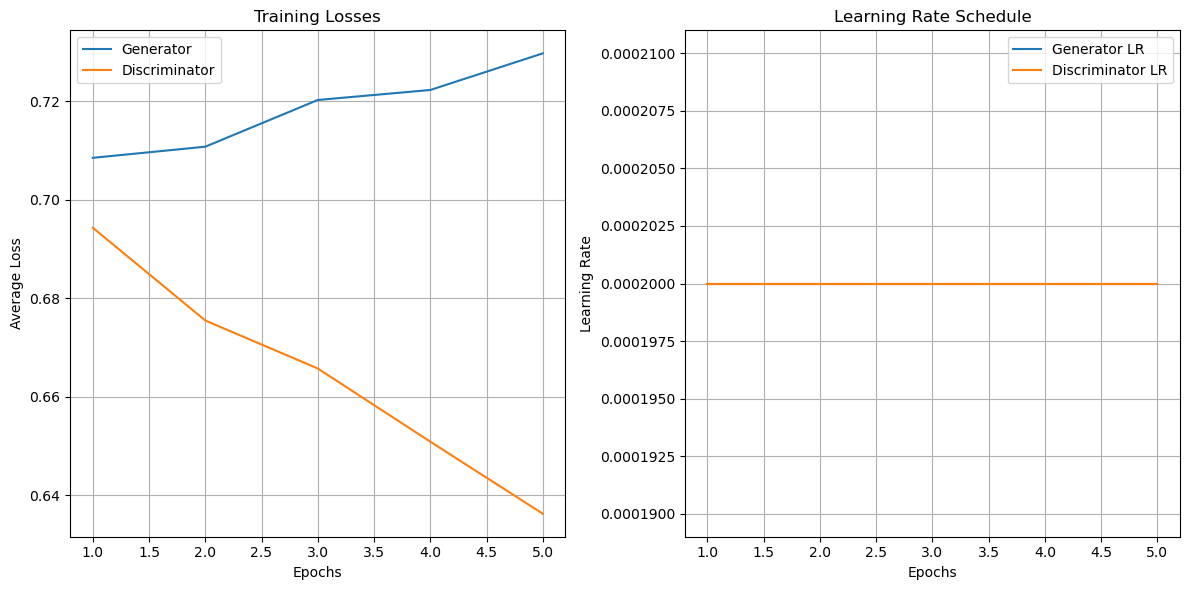

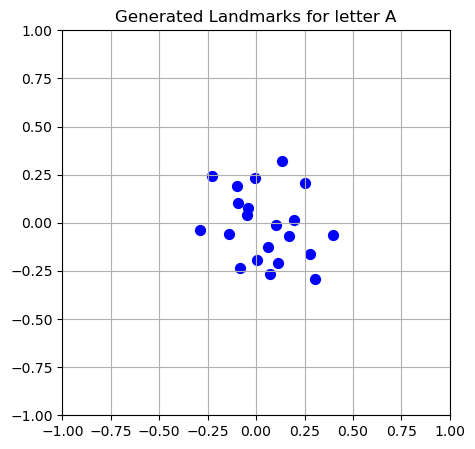

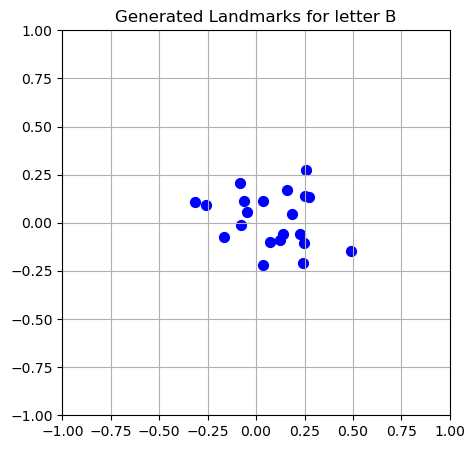

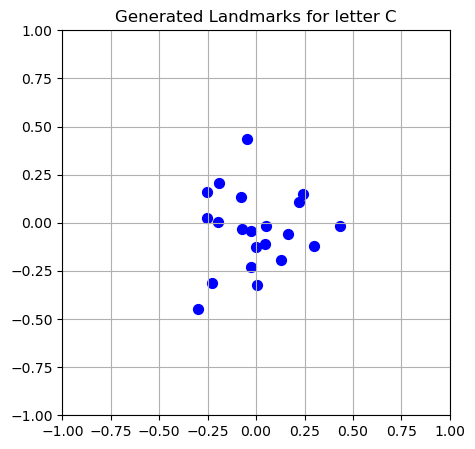

Training Progress:  20%|██        | 6/30 [00:01<00:05,  4.77it/s]


Epoch 6/30
Generator Loss: 0.7338
Discriminator Loss: 0.6295


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 47.41it/s]



Epoch 7/30
Generator Loss: 0.7301
Discriminator Loss: 0.6154


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 44.23it/s]



Epoch 8/30
Generator Loss: 0.7357
Discriminator Loss: 0.5943


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 48.56it/s]



Epoch 9/30
Generator Loss: 0.7582
Discriminator Loss: 0.5931


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 45.18it/s]



Epoch 10/30
Generator Loss: 0.7593
Discriminator Loss: 0.5673


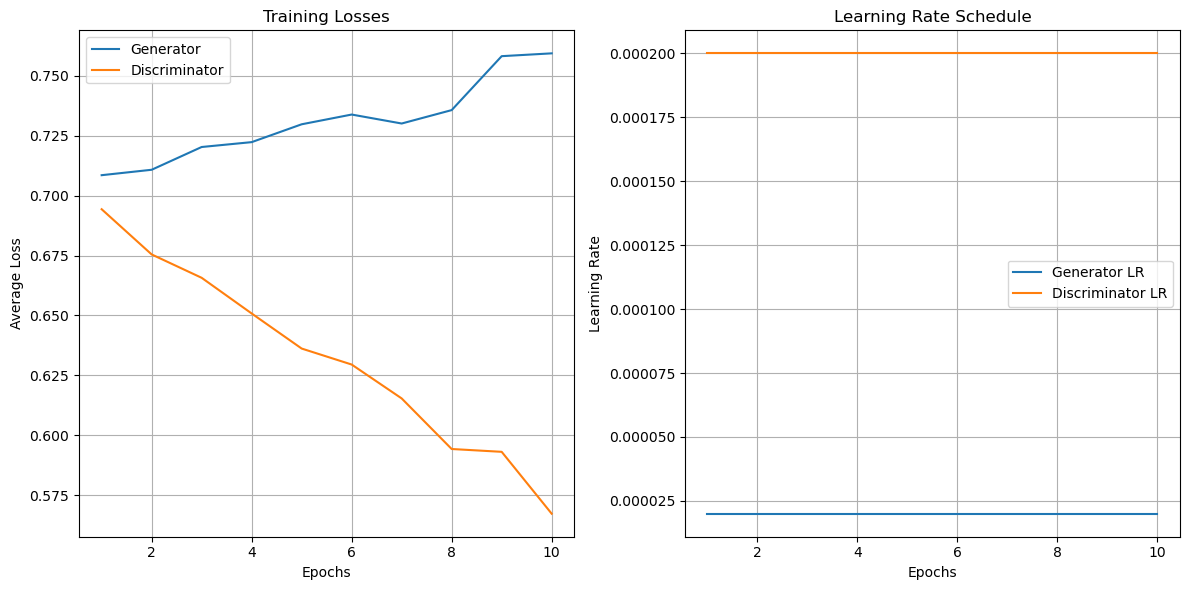

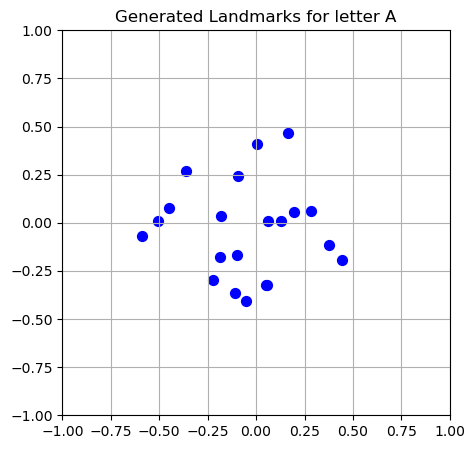

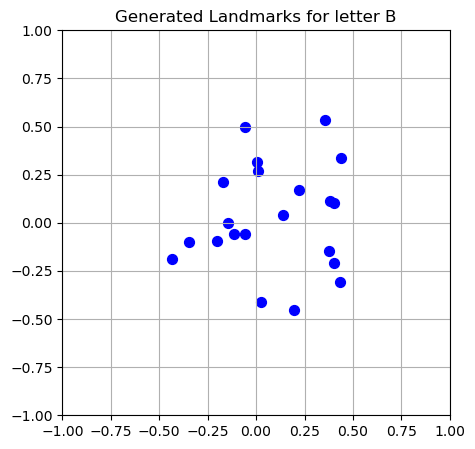

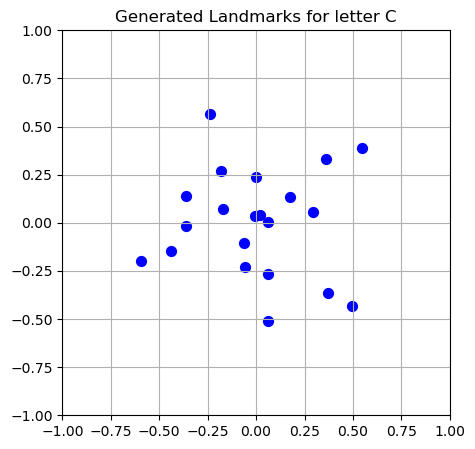

Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 62.34it/s]  4.26it/s]



Epoch 11/30
Generator Loss: 0.7640
Discriminator Loss: 0.5563


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 49.78it/s]



Epoch 12/30
Generator Loss: 0.7746
Discriminator Loss: 0.5515


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 49.62it/s]



Epoch 13/30
Generator Loss: 0.7871
Discriminator Loss: 0.5321


Training Progress:  47%|████▋     | 14/30 [00:02<00:02,  6.89it/s]


Epoch 14/30
Generator Loss: 0.8205
Discriminator Loss: 0.5174


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 46.18it/s]



Epoch 15/30
Generator Loss: 0.7973
Discriminator Loss: 0.5055


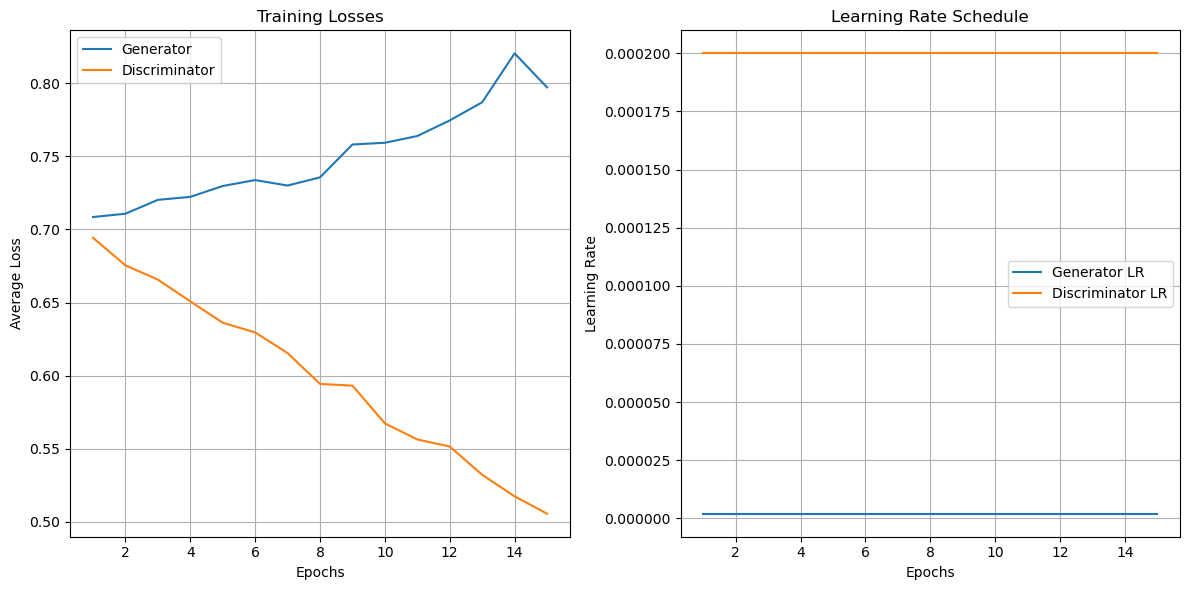

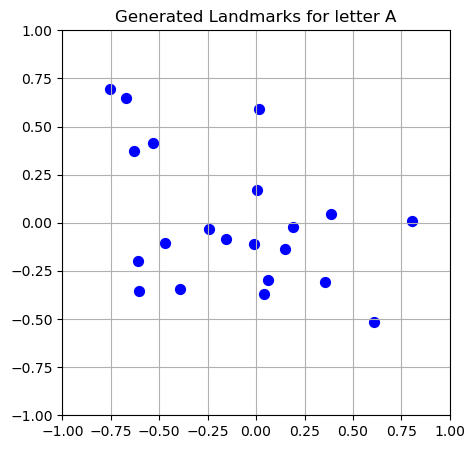

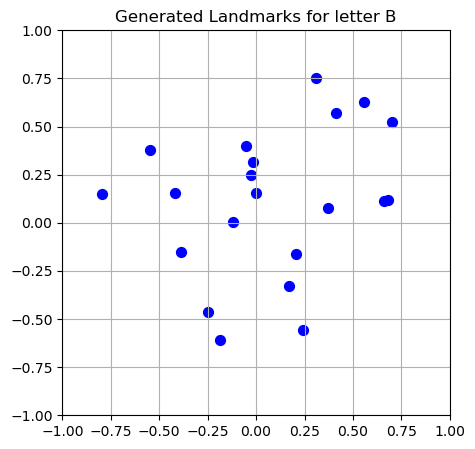

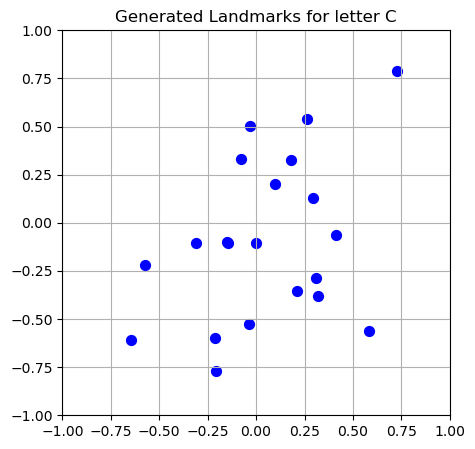

Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 59.91it/s]



Epoch 16/30
Generator Loss: 0.8158
Discriminator Loss: 0.4962


Training Progress:  57%|█████▋    | 17/30 [00:03<00:02,  4.95it/s]


Epoch 17/30
Generator Loss: 0.8519
Discriminator Loss: 0.4683


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 52.44it/s]



Epoch 18/30
Generator Loss: 0.8586
Discriminator Loss: 0.4478


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 41.57it/s]



Epoch 19/30
Generator Loss: 0.8589
Discriminator Loss: 0.4540


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 54.36it/s]



Epoch 20/30
Generator Loss: 0.9015
Discriminator Loss: 0.4278


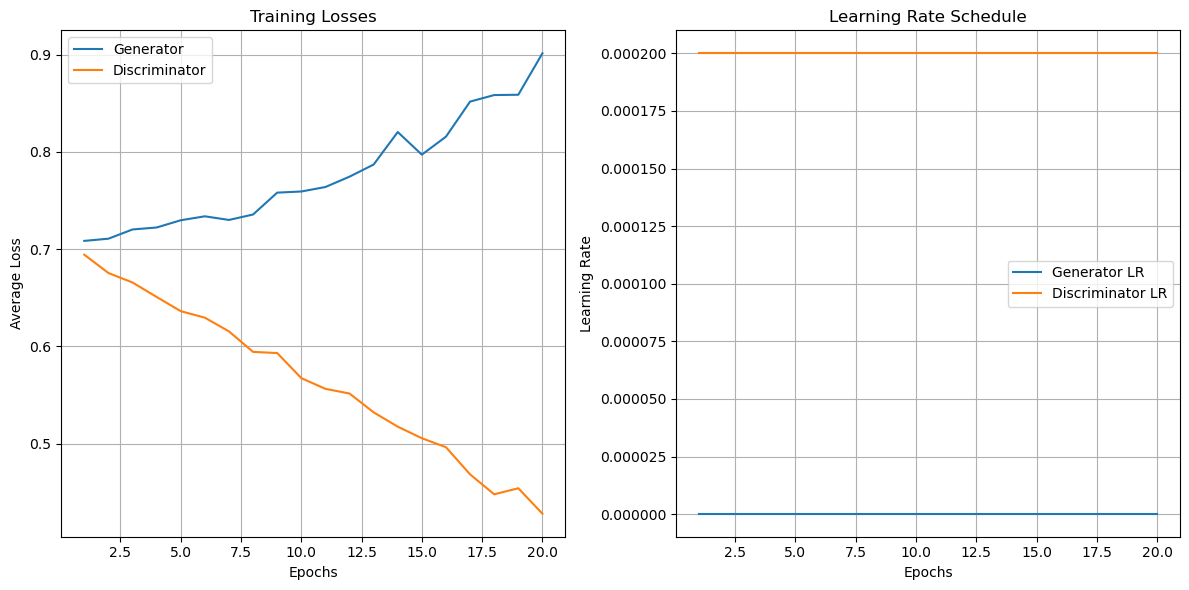

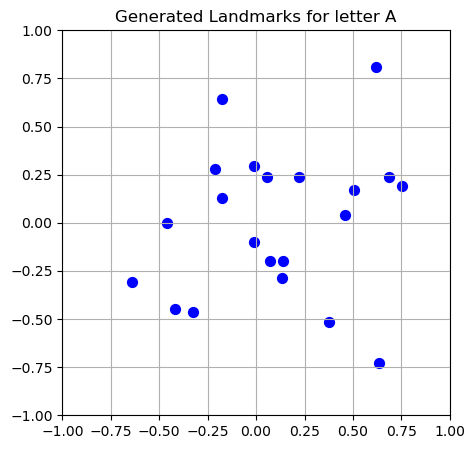

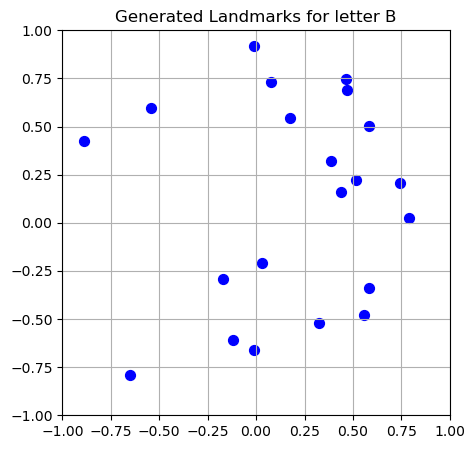

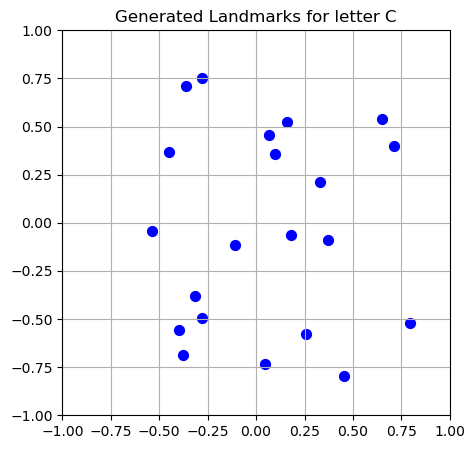

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 37.63it/s]  4.09it/s]



Epoch 21/30
Generator Loss: 0.9138
Discriminator Loss: 0.4189


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 47.48it/s]



Epoch 22/30
Generator Loss: 0.9329
Discriminator Loss: 0.4037


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 47.59it/s]



Epoch 23/30
Generator Loss: 0.9026
Discriminator Loss: 0.3921


Training Progress:  80%|████████  | 24/30 [00:04<00:00,  6.07it/s]


Epoch 24/30
Generator Loss: 0.9781
Discriminator Loss: 0.3667


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]



Epoch 25/30
Generator Loss: 1.0070
Discriminator Loss: 0.3543


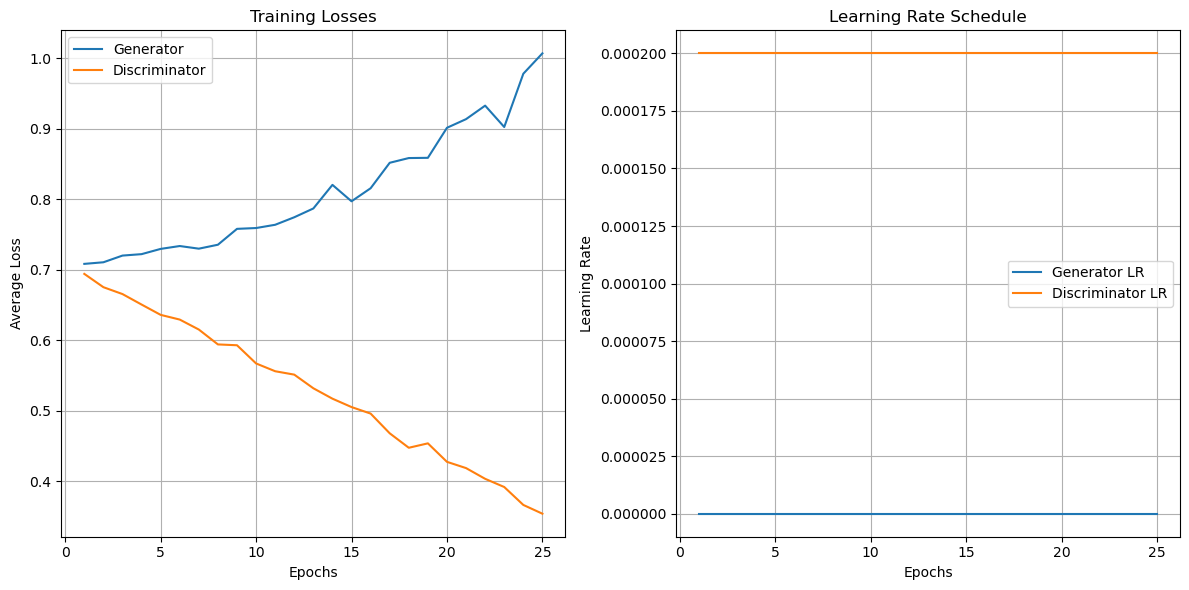

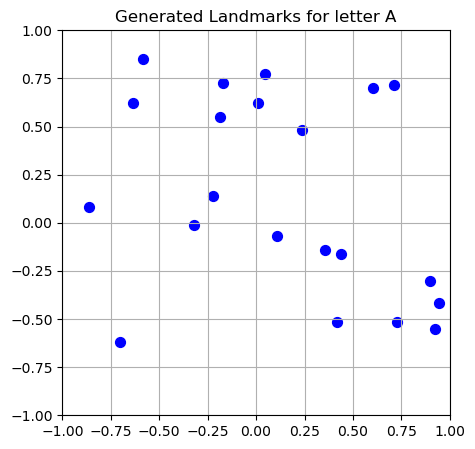

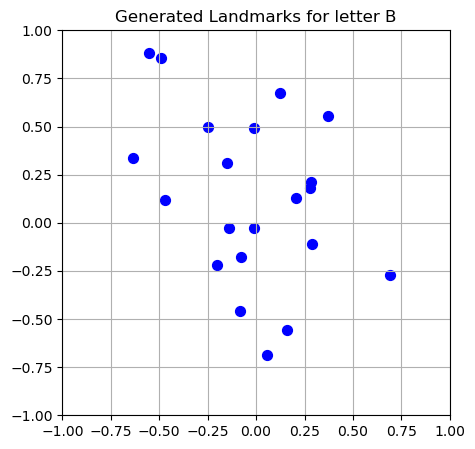

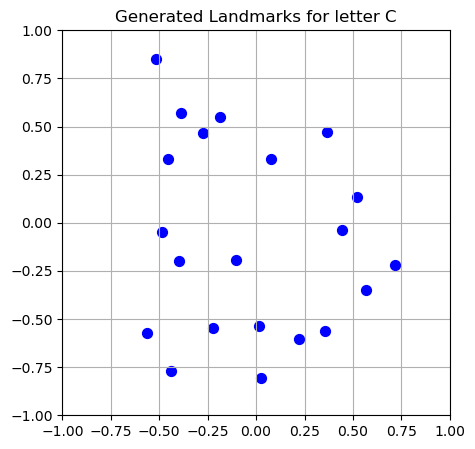

Training Progress:  87%|████████▋ | 26/30 [00:05<00:00,  4.29it/s]


Epoch 26/30
Generator Loss: 1.0365
Discriminator Loss: 0.3582


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 50.98it/s]



Epoch 27/30
Generator Loss: 1.0611
Discriminator Loss: 0.3178


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 50.69it/s]



Epoch 28/30
Generator Loss: 1.0419
Discriminator Loss: 0.3437


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 48.55it/s]



Epoch 29/30
Generator Loss: 1.0816
Discriminator Loss: 0.3248


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]



Epoch 30/30
Generator Loss: 1.1256
Discriminator Loss: 0.3130


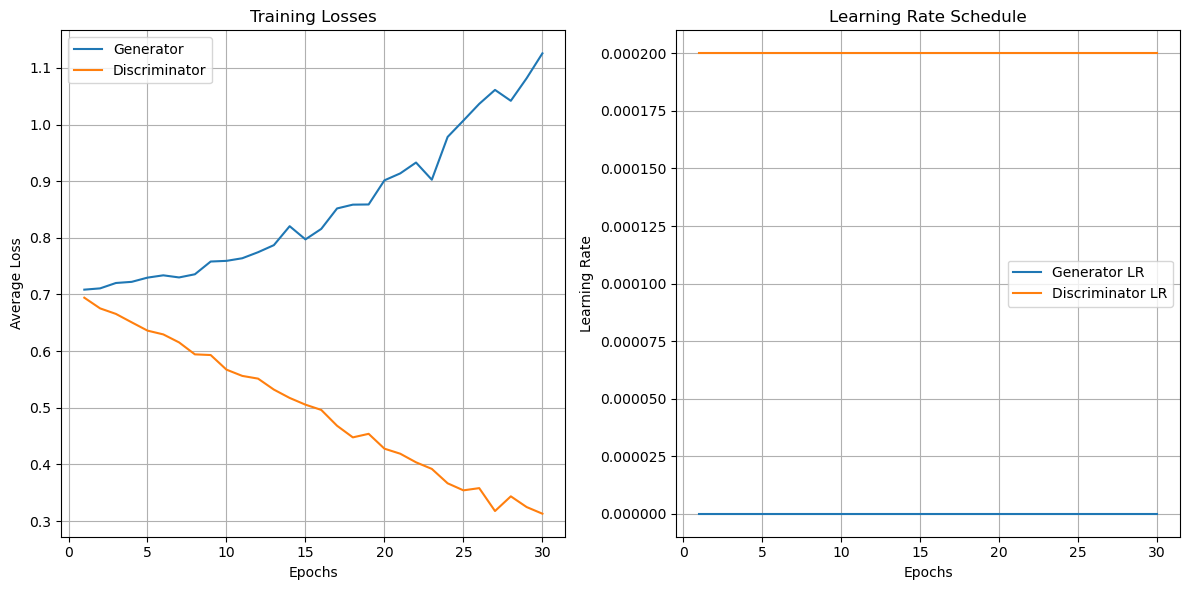

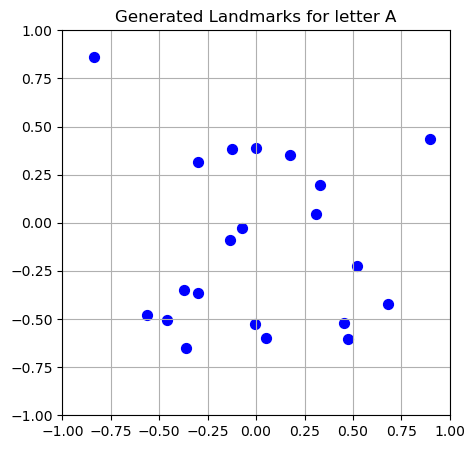

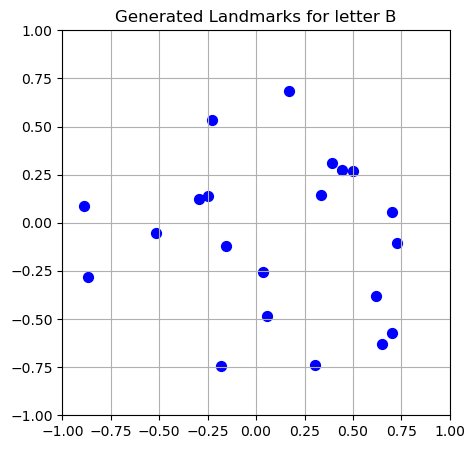

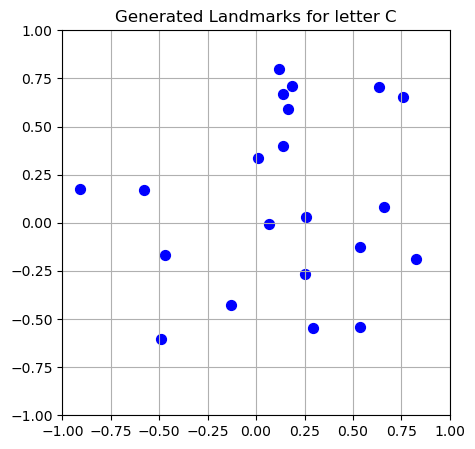

Training Progress: 100%|██████████| 30/30 [00:06<00:00,  4.63it/s]

Training completed!
Saving models...
Models saved to saved_models
Testing model...
Unexpected error: name 'visualize_landmarks' is not defined



C:\Users\HP\AppData\Local\Temp\ipykernel_14624\2812823329.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


NameError: name 'visualize_landmarks' is not defined

In [61]:
import torch
import mediapipe as mp
import cv2
from pathlib import Path
import torch.cuda
from tqdm import tqdm

# Utility Functions
def generate_noise(batch_size, latent_dim=100):
    """Generate random noise vector for GAN"""
    return torch.randn(batch_size, latent_dim)


# 1. Add missing utility functions
def letter_to_onehot(letter):
    """Convert letter to one-hot encoding"""
    encoding = torch.zeros(26)
    encoding[ord(letter.lower()) - ord('a')] = 1
    return encoding

# 2. Define loss function
adversarial_loss = nn.BCELoss()

def get_dataloader(data_path, batch_size=32, shuffle=True):
    dataset = HandLandmarkDataset(data_path)
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=0,  # Single process to avoid worker errors
        pin_memory=True if torch.cuda.is_available() else False
    )

def main():
    # Constants
    DATA_ROOT = './sample2'
    PREPROCESSED_DATA_PATH = './processed_data/landmarks.json'
    MODEL_SAVE_PATH = './saved_models'
    NUM_EPOCHS = 30
    BATCH_SIZE = 32
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    try:
        # Step 1: Preprocessing
        print("Step 1: Preprocessing...")
        preprocessor = LandmarkPreprocessor(
            data_root=DATA_ROOT, 
            save_path=Path('./processed_data')
        )
        Path('./processed_data').mkdir(parents=True, exist_ok=True)
        
        if not Path(PREPROCESSED_DATA_PATH).exists():
            preprocessor.process_dataset()
        else:
            print(f"Using existing preprocessed data from {PREPROCESSED_DATA_PATH}")

        # Step 2: Data Loading
        print("Step 2: Preparing DataLoader...")
        train_loader = get_dataloader(
            PREPROCESSED_DATA_PATH,
            batch_size=BATCH_SIZE,
            shuffle=True
        )

        # Step 3: Model Initialization
        print("Step 3: Initializing models...")
        generator = Generator().to(DEVICE)
        discriminator = Discriminator().to(DEVICE)

        # Step 4: Training
        print("Step 4: Training GAN...")
        trainer = GANTrainer(
            generator=generator,
            discriminator=discriminator,
            device=DEVICE
        )

        trainer.train(train_loader, num_epochs=NUM_EPOCHS)

        # Step 5: Save Models
        print("Saving models...")
        save_path = Path(MODEL_SAVE_PATH)
        save_path.mkdir(parents=True, exist_ok=True)
        
        torch.save({
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict()
        }, save_path / 'gan_model.pth')
        print(f"Models saved to {save_path}")

        # Step 6: Testing
        print("Testing model...")
        tester = ModelTester(
            model_path=save_path / 'gan_model.pth',
            device=DEVICE
        )
        
        test_letters = ['A', 'B', 'C']
        test_results = tester.evaluate_generation(letters=test_letters)

        # Step 7: Visualization
        print("Displaying results...")
        for letter, result in test_results.items():
            print(f"Showing landmarks for letter: {letter}")
            cv2.imshow(f"Letter {letter}", result['visualization'])
            cv2.waitKey(0)
        
        cv2.destroyAllWindows()

    except FileNotFoundError as e:
        print(f"File not found error: {str(e)}")
        raise
    except RuntimeError as e:
        print(f"Runtime error (possibly CUDA): {str(e)}")
        raise
    except Exception as e:
        print(f"Unexpected error: {str(e)}")
        raise
    finally:
        cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

In [39]:
# Test the functions
test_letter = 'A'
one_hot = letter_to_onehot(test_letter)
print(f"One-hot encoding for {test_letter}:", one_hot)

# Create dataloader
train_loader = get_dataloader('processed_data/landmarks.json')

One-hot encoding for A: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
